In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
BAC = data.DataReader("BAC", data_source="yahoo", start = "2000-01-01", end = "2019-06-01")
BAC.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,25.12500,24.00000,25.12500,24.21875,13705800.0,12.253836
2000-01-04,23.96875,22.46875,23.87500,22.78125,27293400.0,11.526516
2000-01-05,23.21875,22.25000,22.53125,23.03125,22855600.0,11.653006
2000-01-06,25.00000,23.37500,23.46875,25.00000,17307000.0,12.649126
2000-01-07,24.81250,24.00000,24.81250,24.34375,11632800.0,12.317083


In [7]:
BAC.shape

(4878, 6)

In [13]:
BAC_train = BAC.iloc[:4000, :]
BAC_train.shape

(4000, 6)

In [14]:
BAC_test = BAC.iloc[4000:, :]
BAC_test.shape

(878, 6)

In [15]:
training_set = BAC.iloc[:4000, 2:3].values
training_set

array([[25.125     ],
       [23.875     ],
       [22.53125   ],
       ...,
       [17.80999947],
       [17.62000084],
       [17.26000023]])

In [16]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 3999):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
3939/3939 [==============================] - 44s 11ms/step - loss: 0.0147
Epoch 2/100
3939/3939 [==============================] - 38s 10ms/step - loss: 0.0040
Epoch 3/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0039
Epoch 4/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0036
Epoch 5/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0031
Epoch 6/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0028
Epoch 7/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0028
Epoch 8/100
3939/3939 [==============================] - 36s 9ms/step - loss: 0.0025
Epoch 9/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0024
Epoch 10/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0023
Epoch 11/100
3939/3939 [==============================] - 37s 9ms/step - loss: 0.0022
Epoch 12/100
3939/3939 [==============================] - 37s

3939/3939 [==============================] - 67s 17ms/step - loss: 7.7418e-04
Epoch 95/100
3939/3939 [==============================] - 60s 15ms/step - loss: 8.1890e-04
Epoch 96/100
3939/3939 [==============================] - 38s 10ms/step - loss: 8.2734e-04
Epoch 97/100
3939/3939 [==============================] - 37s 10ms/step - loss: 8.8086e-04
Epoch 98/100
3939/3939 [==============================] - 38s 10ms/step - loss: 8.4279e-04
Epoch 99/100
3939/3939 [==============================] - 38s 10ms/step - loss: 8.6098e-04
Epoch 100/100
3939/3939 [==============================] - 38s 10ms/step - loss: 8.7095e-04


In [18]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock prices until 2019
real_stock_price = BAC_test.iloc[:, 2:3].values

In [26]:
# Getting the predicted stock prices until 2019
BAC_total = pd.concat((BAC_train['Close'], BAC_test['Close']), axis = 0)
inputs = BAC_total[len(BAC_total) - len(BAC_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 938):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

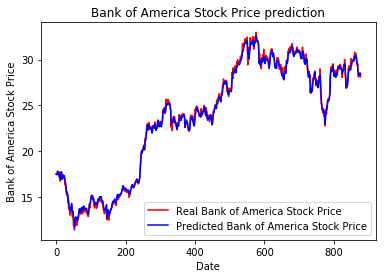

In [27]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Bank of America Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Bank of America Stock Price')
plt.title('Bank of America Stock Price prediction')
plt.xlabel('Date')
plt.ylabel('Bank of America Stock Price')
plt.legend()
plt.show()

In [28]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

0.30791155273344384

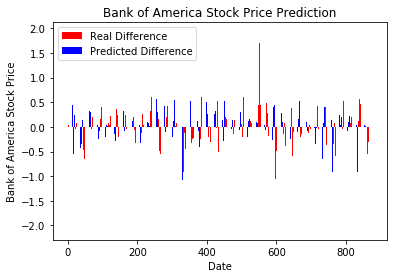

In [29]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Bank of America Stock Price Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Bank of America Stock Price')
ax.legend()
plt.show()